# Homework 4: Building and Training Convolutional Networks
When you download the file into your Google Drive, please insert your name and student ID number here by replacing my name in the fields below.

RITIK TOMAR   ID: 557603124


# Convolutional Neural Networks

Welcome to your fourth assignment! You have previously built and trained a deep Fully Connected (FC) Neural Network with L layers using Pytorch. In this  assignment, you will use PyTorch to put together a ConvNet and train it on the CIFAR-10 image data using a softmax backend.

In this notebook, you will implement and train a CNN to learn what is in the ten classes of images. This will enable you to start learning the PyTorch framework for deep learning.

*   Uses the PyTorch dataloader function
*   Use PyTorch *nn* to create an instance of a convolutional network
*   Visualization functions to see what is happening as the network goes deeper.

**After this assignment you will be able to:**
- Alter the structure of a model.
- Explain how a ConvNet works with its successive layers.
- Visualize results from a multiclass classifier using a heatmap and a confusion matrix.

**There code that you need to fill in this assignment**
See sections 3.1, 3.2, and 3.3.

**There are questions that you need to answer in this assignment**
The questions are in section 6!



## 1.0 - Import packages


Now, let's first import all the packages that you will need during this assignment.
- [numpy](www.numpy.org) is the main package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- pytorch
- pytorch nn

In [ ]:
!pip install torchinfo
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 30.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchmetrics


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


np.random.seed(2023)

## 2 - Outline of the Assignment

 Here is an outline of this assignment, you will:

1.  Read in the CIFAR-10 training and testing data
2.  Review how minibatches are implemented in PyTorch.
3.  Create a PyTorch Model of a CNN using the module function in PyTOrch
4.  Choose an optimizer and objective function for the model.
5.  Train the model.
6.  Visual the results at selected layers of the network.



### 2.1 Read in and process the data set
PyTorch provides data loaders for common data sets used in vision applications, such as MNIST, CIFAR-10 and ImageNet through the [*torchvision*](https://pytorch.org/docs/stable/torchvision/index.html) package. The *torchvision* package consists of popular datasets, model architectures, and common image transformations for computer vision. Other handy tools are the *torch.utils.data.DataLoader* that we will use to load the data set for training and testing and the *torchvision.transforms*, which we will use to compose a two-step process to prepare the data for use with the CNN.

First step is to convert Python Image Library (PIL) format
to PyTorch tensors.

Second step is used to normalize the data by specifying a
mean and standard deviation for each of the three channels.
This will convert the data from [0,1] to [-1,1]

Normalization of data should help speed up conversion and
reduce the chance of vanishing gradients with certain
activation functions.

There are 50000 training examples and 10000 testing examples in the CIFAR-10 dataset at https://www.cs.toronto.edu/~kriz/cifar.html. for more details see: Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.

Code from: [Stefan Fiott](https://www.stefanfiott.com/machine-learning/cifar-10-classifier-using-cnn-in-pytorch/)

In [ ]:
import torchvision
import torchvision.transforms as transforms

# Initialize transform function to convert to PyTorch tensors
# Normalize: standardizes each channel of the input using a mean of 0.5 and a std
# of 0.5
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

print(len(trainset), ' training images')
print(trainset.class_to_idx)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# Set up a batch data loader for image display
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



100%|██████████| 170M/170M [00:03<00:00, 49.3MB/s]


50000  training images
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


### 2.2 Display the images

Using the trainloader we will now get a random batch of 4 training images and plot them to see what CIFAR-10 images look like.

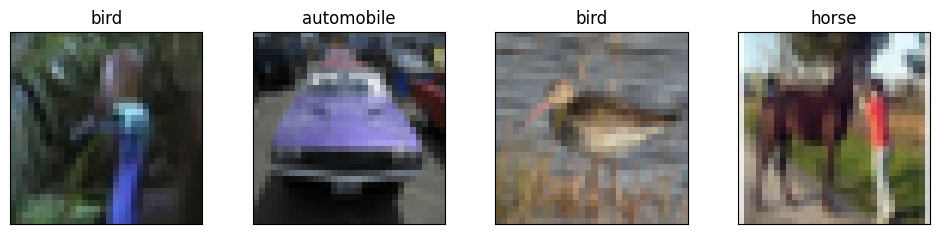

In [ ]:
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)


# can change to testloader to see four test images
data_iter = iter(trainloader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

## 3 - Setting up a Simple Convolutional Network

The network has the following layout,

*Input > Conv (ReLU) > MaxPool > Conv (ReLU) > MaxPool > FC (ReLU) > FC (ReLU) > FC (SoftMax) > 10 outputs*


where:

*Conv* is a convolutional layer, *ReLU* is the activation function, *MaxPool* is a pooling layer, *FC* is a fully connected layer and *SoftMax* is the activation function of the output layer.


## 3.1 Layer dimensions


```
Layer Name    | Layer Size
______________|______________________________________________________
Input         | 32x32x3, i.e., 3 channels each of size 32x32 pixels
Conv Layer 1  | 5x5x3 filters, s=1, p="same", 16 filters
Max Pool 1    | 2x2 with stride = 2
Conv Layer 2  | 3x3x16 filters, s=1, p="valid", 32 filters
Max Pool 2    | 2x2 with stride = 2
FC 1          |  (1568) x 200 Nodes + bias
FC 2          |  200 by 84 Nodes + bias
FC 3          |  84 by 10 Nodes + bias
Output        | 10 Nodes
```

**PyTorch Functions**

*Conv2d(n_input_channels, n_output_channels, f(filter size))*

MaxPool2d(size, stride)

nn.Linear(input_dim, output_dim)*





**Fill in the code defining the model below.**


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class HW3Net(nn.Module):
    def __init__(self):
        super(HW3Net, self).__init__()
        # define each layer here
        self.conv1 = nn.Conv2d(3, 16, 5, stride=1, padding="same")
        self.pool =  nn.MaxPool2d(2, 2)
        self.conv2 =  nn.Conv2d(16, 32, 3, stride=1, padding="valid")
        self.fc1 =  nn.Linear(1568, 200)
        self.fc2 =  nn.Linear(200, 84)
        self.fc3 =  nn.Linear(84, 10)

    def forward(self, x):
      # Define the forward Path of the model here
      # Convolution and pooling layers
        # Convolution Layer 1
        x = self.pool(F.relu(self.conv1(x)))
        # Convolution Layer 2
        x = self.pool(F.relu(self.conv2(x)))

        # reshape the output for the FC layers
        # Hint: replace None with the product of the dimensions of the Conv layer 2 after pooling
        x = x.view(-1, 1568)

        # Fully Connected layers
        x = F.relu(self.fc1(x))  #FC Layer 1
        x = F.relu(self.fc2(x))  #FC Layer 2
        x = self.fc3(x)  #FC Layer 3
        return x

# Instantiate your network as net
net = HW3Net()
print('HW3Net model is: ', net)


HW3Net model is:  HW3Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (fc1): Linear(in_features=1568, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 3.2 - Defining the Loss Function and Optimization

Since we are classifying images into more than two classes we will use cross-entropy as a loss function. To optimize the network we will employ stochastic gradient descent (SGD) with momentum to help get us over local minima and saddle points in the loss function space. Use a learning rate of 0.001 and a momentum value of 0.9.

Look at the documentation in torch.nn for the loss function(https://pytorch.org/docs/stable/nn.html#loss-functions) and torch.optim to find the proper optimization function (https://pytorch.org/docs/stable/optim.html).


Fill in the code defining the loss function and optimizer below. Try to use at least one type of regularization.

In [ ]:
import torch.optim as optim

# Select the appropriate criteria from torch.optim package:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4) # Added weight decay for regularization
num_epoch = 6 #run for 1 epoch first until you feel good about your model.
batch_size = 16

### 3.3 - Training the Network

We will now set up to train the network using the trainloader data, by going over all the training data in batches of 16 images, and repeating the whole process num_epoch times. Every 1000 batches (16K images), we report on training progress by printing the current epoch and batch number along with the running loss value.

Once training is complete, we will save the model parameters to disk. This will make it possible to load the model parameters from disk the next time we run this notebook and thus not have to train the model again, saving some time. More details on how to save and load model parameters can be found here.



Note: Ignore the warning shown below. It is a known bug in PyTorch that was reported this summer.
*/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)*
.


In [ ]:
import os
pwd = os.getcwd()
modelpath = "cifar-10-cnn-model.pt"
full_modelpath = os.path.join(pwd, modelpath)
print(full_modelpath)

/content/cifar-10-cnn-model.pt


In [ ]:
#Set flags for saving and loading file
load_flag = "FALSE" #if true, a previously saved model will be loaded

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size,
                                          shuffle=True, num_workers=2)

# Saving your model is useful if you would like to save your results then go back and train more later.
if (load_flag == "TRUE"):#os.path.isfile(full_modelpath):
    # load trained model parameters from disk
    net.load_state_dict(torch.load(full_modelpath))
    print('Loaded model parameters from disk, so no need to retrain.')
    net.eval()

for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0 # compute loss per epoch
    # Loop through iterable containing training data
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # forward pass
        outputs = net(inputs)

        # compute loss
        loss = criterion(outputs,labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Perform backpropagation 2 steps, loss then optimizer
        # Loss computation
        loss = criterion(outputs, labels)
        loss.backward()
        # Optimizer
        optimizer.step()


        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    print('Finished Epoch %d',(epoch+1))

# save the trained model to disk
torch.save(net.state_dict(), full_modelpath)
print('Saved model parameters to disk.', full_modelpath)

[1,  1000] loss: 1.147
[1,  2000] loss: 1.106
[1,  3000] loss: 1.092
Finished Epoch %d 1
[2,  1000] loss: 1.005
[2,  2000] loss: 0.981
[2,  3000] loss: 0.979
Finished Epoch %d 2
[3,  1000] loss: 0.903
[3,  2000] loss: 0.893
[3,  3000] loss: 0.875
Finished Epoch %d 3
[4,  1000] loss: 0.800
[4,  2000] loss: 0.810
[4,  3000] loss: 0.788
Finished Epoch %d 4
[5,  1000] loss: 0.711
[5,  2000] loss: 0.740
[5,  3000] loss: 0.730
Finished Epoch %d 5
[6,  1000] loss: 0.621
[6,  2000] loss: 0.655
[6,  3000] loss: 0.663
Finished Epoch %d 6
Saved model parameters to disk. /content/cifar-10-cnn-model.pt


In [ ]:
# Compute Training Accuracy
from torchmetrics import Accuracy
accuracy = Accuracy(task='MULTICLASS', num_classes = len(classes))
accuracy = accuracy(outputs, labels)
print('[Training Accuracy]: ', accuracy*100)

[Training Accuracy]:  tensor(75.)


## 4. Testing the Model
Now that the network is trained, we can evaluate how it performs on the testing data set. Start with four random images from the testing data set and their corresponding labels.

**Four Random Images and their class (category) predictions**

First, we input four images to the trained network to get class (label/category) predictions.

The network outputs a 2D tensor (array) of size 4x10, a row for each image and a column for each category. The values are raw outputs from the linear transformation, $z^{[l]} = W^{[l]} a^{[l-1]} + b^{[l]}$

The category predicted for each image (row) is thus the column index containing the maximum value in that row.

tensor([[ 6.5160e+00,  1.0134e+00,  4.7464e-01, -3.1697e+00, -9.1500e-01,
         -7.4673e+00, -2.3926e+00, -6.1052e+00,  1.1553e+01,  2.3553e-01],
        [ 3.2924e+00,  4.7287e+00, -1.0233e+00, -3.4350e+00, -3.5667e+00,
         -3.2228e+00, -1.7650e+00, -2.7760e+00,  3.9843e+00,  3.5192e+00],
        [ 4.5139e-01,  2.2511e+00, -1.2352e+00, -1.0835e+00, -7.9631e-01,
         -1.4341e+00, -7.3523e-02,  4.6435e-03,  3.1811e+00, -4.0426e-01],
        [ 1.5327e+00,  2.7214e+00, -3.5748e+00, -1.8487e+00, -9.7413e-01,
         -2.8187e+00, -1.0795e+00, -8.0821e-01, -1.1736e+00,  8.2816e+00]],
       grad_fn=<AddmmBackward0>)

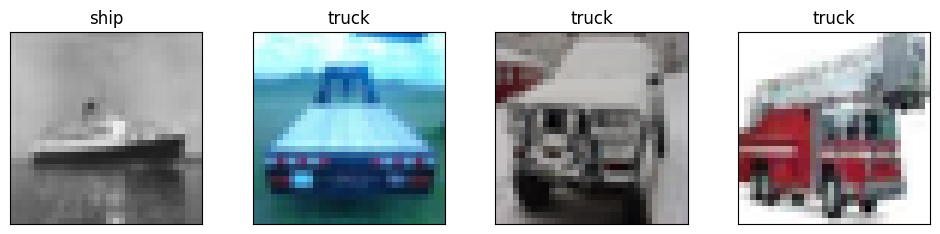

In [ ]:
data_iter = iter(testloader)
# images, labels = data_iter.next()
images, labels = next(data_iter)

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

outputs = net(images)
outputs

 **Probability Score and Class Prediction**

 To get a probability score, use the *nn.Softmax* function on the raw output as shown below. The predicted category is the one with the maximum probability score.

In [ ]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)
print("Probability Score:",sm_outputs)

probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))

Probability Score: tensor([[6.4496e-03, 2.6288e-05, 1.5339e-05, 4.0092e-07, 3.8218e-06, 5.4531e-09,
         8.7211e-07, 2.1290e-08, 9.9349e-01, 1.2076e-05],
        [1.1788e-01, 4.9570e-01, 1.5746e-03, 1.4119e-04, 1.2376e-04, 1.7457e-04,
         7.4995e-04, 2.7290e-04, 2.3548e-01, 1.4790e-01],
        [4.0206e-02, 2.4317e-01, 7.4444e-03, 8.6636e-03, 1.1546e-02, 6.1017e-03,
         2.3786e-02, 2.5720e-02, 6.1627e-01, 1.7088e-02],
        [1.1658e-03, 3.8270e-03, 7.0548e-06, 3.9636e-05, 9.5043e-05, 1.5026e-05,
         8.5536e-05, 1.1220e-04, 7.7857e-05, 9.9457e-01]],
       grad_fn=<SoftmaxBackward0>)
ship - 0.9935
automobile - 0.4957
ship - 0.6163
truck - 0.9946


**Testing Predictions for all Test Images**

We will now loop through all of the test images to see how we did. I got an accuracy of around 65% after 5 epochs, around 70-72% for 10 epochs.

In [ ]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1

model_accuracy = total_correct / total_images * 100
print('[Testing Accuracy] Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

[Testing Accuracy] Model accuracy on 10000 test images: 69.39%


## 5. Visualizing the Results
Now that the network is trained, we can visualize the results to investigate the conditions where the model works well and when it makes mistakes using some visualization tools from statistical graphics.

**Confusion Matrix Computation**

The model performed much better than random guessing, which would give us an accuracy of 10% since there are ten categories in CIFAR-10. The confusion matrix computes the accuracy of the model per category so we can see if there are particular categories that are being confused with one another. This matrix can be visualized as a heatmap. The squares show the matches between the input images and what the model guessed.

What type of image were deer misclassified as most often?

Category   - Accuracy
airplane   - 80.0
automobile - 78.8
bird       - 59.6
cat        - 58.0
deer       - 59.0
dog        - 57.4
frog       - 77.7
horse      - 75.4
ship       - 81.1
truck      - 66.9


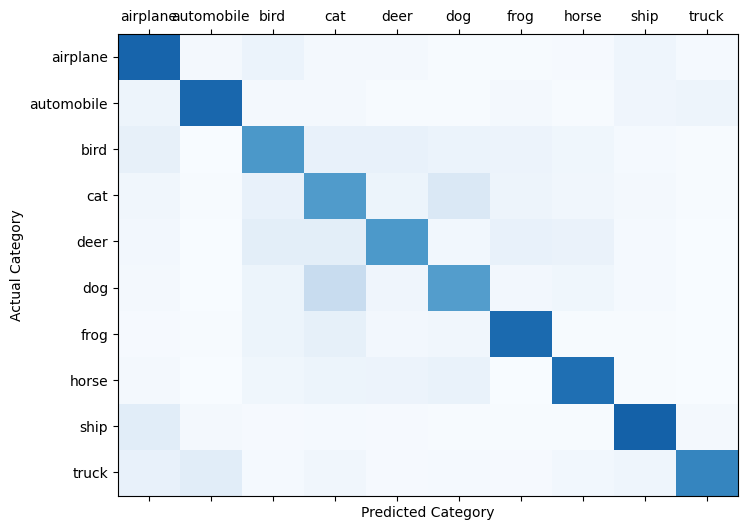

In [ ]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

**Confusion Matrix**

From the above heatmap visualisation, we can see where the best accuracy was achieved, the darkest shades present on the main diagonal.

To understand precisely which categories were most commonly confused, we can print the percentage and absolute values of the confusion matrix below.

In [ ]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     airplane  automobilebird      cat       deer      dog       frog      horse     ship      truck     
airplane        800       19        62        22        18        4         7         10        43        15        
                0.8       0.019     0.062     0.022     0.018     0.004     0.007     0.01      0.043     0.015     
automobile      48        788       18        18        6         4         21        6         41        50        
                0.048     0.788     0.018     0.018     0.006     0.004     0.021     0.006     0.041     0.05      
bird            81        2         596       78        73        60        56        37        12        5         
                0.081     0.002     0.596     0.078     0.073     0.06      0.056     0.037     0.012     0.005     
cat             32        7         75        580       52        143       50        33        22        6         
                0.032     0.007     0.075     0.58      0.052   

# 6. Analysis Questions

Your homework score will be based on
1. the coding of the model (20 points) in sections 3.1, 3.2 and 3.3.
2. the answers of the questions below.

## 6.1 Convolution Nets Questions (20 points)
**Question 1**
What categories of images were identified most accurately? Which categories were confused with each other more often? Use your results from Part 5 to inform your answers. Speculate on why some categories of image were more difficult to work with.

**Answer: The "horse" and "ship" categories achieved the maximum accuracy, according to my analysis of the confusion matrix.  The deepest hues along the major diagonal, which show great accuracy in these classes, make this clear.  Nonetheless, there was clear confusion between the "dog" and "cat" categories, indicating possible visual similarities that might be leading to incorrect classifications.  In a similar vein, the "truck" and "automobile" categories showed a higher likelihood of misclassification, maybe as a result of similar background colors and textures.  The model's ability to differentiate between these groups may be enhanced by more research into these visual characteristics.**

**Question 2** Compare your results with those of HW 3 in terms of accuracy across classes, speed of training, and number of parameters.

**Answer:**

**I utilized the following hyperparameters in the HW 3: (i) 'hidden_dims' consists of [512, 256]; (ii) 'activations' are defined as [ReLU(), ReLU()]; (iii) 'learning_rate' is set to 0.01; (iv) 'optimizer' is 'SGD' with weight decay set to 5*10^4; and (v) a CosineAnnealingLR scheduler with T_max=200.  Training accuracy was 66.5225%, validation accuracy was 54.53%, and test accuracy was 53.74%.**

**In this HW 4, I obtained Training Accuracy: 75.5%, and Test Accuracy on 10000 images: 69.39%. It seems the model is overfit. It clearly demonstrates that Convolutional neural networks trained much better the image dataset than FC neural networks. The speed of training in CNN is faster than the FC-based model in HW3. And, the CNN-based model has a smaller number of parameters compared to FC-based models of similar depth. It is because CNNs use shared weights in convolutional layers, which is more parameter-efficient for image data, as discussed in the class.**

**Question 3** Describe two methods for data augmentation and how they might improve system performance.

**Answer:**

**Image Rotation and Flipping: Using this method, we flip the dataset's photos horizontally (from left to right) and rotate them by different degrees (such as 90, 180, or 270 degrees).  If necessary, we can also execute vertical flips.  As discussed in class, the model becomes more space-invariant to the orientation of objects in the images by performing rotations and flips.  For instance, a dog in CIFAR-10 should be identified regardless of where it is in the picture.  Flips and rotations make the model more resilient by improving its ability to generalize to other orientations.**

**Random Cropping and Padding: Before feeding the input photos into the CNN, we randomly crop and pad them to various sizes.  Variations in object scales and placements can be simulated by adding padding or randomly choosing a smaller portion of an image.  The model's capacity to identify items at various scales and locations within a picture can be improved by random cropping and padding.  It is especially useful when real-world objects can have varied sizes or appear in different positions.  For CIFAR-10, objects may seem off-center or at various scales in some photos and centered in others.  The model's ability to detect items in many environments is improved by training it on a variety of variations.**

**Extra Credit** (Up to 5 additional points)
If you have time, try to implement increasing the size of the training data set by using the PyTorch data augmentation code See <a href="https://pytorch.org/vision/0.15/transforms.html" target="_blank" rel="noopener">Transforming and Augmenting Images</a>. There are some good tutorials on the PyTorch site for you to review. You must cite any tutorials/examples that you used and clearly state which type of augmentation you tried.

**Answer: I tried a variety of transform techniques after learning about them from the aforementioned link, and I saw how accurate the training and testing were.  I attempted the following transforms at the aforementioned data loaders.**

  #  transforms.RandomCrop(32, padding=4),
  #  transforms.RandomHorizontalFlip(p=0.5),
  # transforms.Resize((32,32)),  #resizes the image so it can be perfect for our model.
  # transforms.RandomHorizontalFlip(), # Flips the image in horizontal axis
  transforms.RandomRotation(10),     #It rotates the image to a specified angel
  # transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.

**I noticed that RandomRotation produced marginally improved testing accuracy results.  In comparison to my previous testing accuracy of 68.93%, the model appears to have performed well, as seen by the training accuracy of 75% and the testing accuracy of 72.07%.  Additionally, it shows how to use transforms methodology to mitigate the overfit.**

## 6.2 Concept Questions (10 points)
Answer each question and give an explanation for why it is true.

1. Which of the following are true of pooling layers in CNNs?
a. They reduce the size of the input to the next layer.
b. They increase the number of parameters.
c. They reduce the number of connections to the next layer.
d. They reduce the number of parameters

**Answer:**

**(a) True: Pooling layers reduce the spatial dimensions (width and height) of the input feature maps**

**(b) False: Pooling layers do not introduce additional parameters.**

**(c) True: Pooling layers reduce the number of connections to the next layer by down-sampling the feature maps.**

**(d) True: Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network [https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/]**

2. Which of the following are true of convolutional neural networks for image analysis?

a. Filters in earlier layers tend to include edge detectors.
b. Pooling layers reduce the spatial resolution of the image.
c. They have more parameters than fully-connected networks with the
same number of layers and the same number of neurons in each layer.
d. A CNN can be trained for unsupervised learning tasks, whereas an ordinary neural net cannot.

**Answer:**

**(a) True: Yes, in earlier layers, we often capture low-level features, such as edges, corners, and textures.**

**(b) True: Yes, we use pooling layers to reduce spatial dimension.**

**(c) False: No, CNNs share weights that significantly reduce number of parameters compared to FC networks.**

**(d) False: No, Both CNN and ordinary neural networks can be used for unsupervised learning tasks.**







3. What is the valid convolution of the filter F with image X?
$$X = \begin{bmatrix}1 & 1 & 4 & 4\\
1 & 1 & 4 & 4\\
4 & 4 & 1 & 1\\
4 & 4 & 1 & 1
\end{bmatrix}$$

$$K = \begin{bmatrix}1 & 1 & 1\\
1 & -6 & 1\\
1 & 1 & 1\\
\end{bmatrix}$$

In [ ]:
# Q3's Answer: Script for solving convolution of the filter F with image X.

import numpy as np
from scipy.signal import convolve2d

# Define the image X and the filter K
X = np.array([[1, 1, 4, 4],
              [1, 1, 4, 4],
              [4, 4, 1, 1],
              [4, 4, 1, 1]])

F = np.array([[1, 1, 1],
              [1, -6, 1],
              [1, 1, 1]])

# Use the convolve2d function to perform the convolution
result = convolve2d(X, F, mode='valid')

print("Result of valid convolution of the filter F with image X:")
print(result)

Result of valid convolution of the filter F with image X:
[[14 -4]
 [-4 14]]


4.What is the result of performing **average pooling** on the image X? Use a 2 x 2 kernel, with stride of 2, and padding with values of (1, 1) pixel on the right side and bottom of the image.

$$X = \begin{bmatrix}1 & 17 & 43 & 4 & 5\\
2 & 2 & 6 & 8 & 7\\
12 & 9 & 4 & 45 & 5\\
3 & 4 & 78 & 9 & 62\\
12 & 11 & 14 & 42 & 15\\
\end{bmatrix}$$

Answer:

I selected the below pooling kernel because it's a simple and commonly used kernel for average pooling.
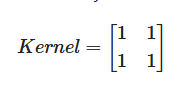


In average pooling, the purpose of the kernel is to sum the values in the region it covers and then divide the sum by the number of elements in that region to obtain the average value.
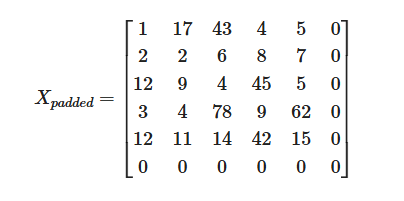



Region (0, 0): Take the first 2x2 region in the top-left corner:
  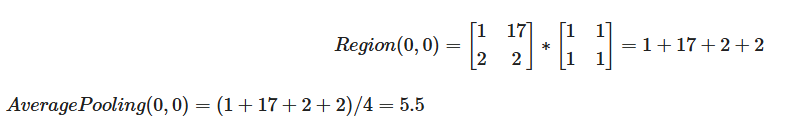



Region (0, 2): Move the kernel 2 pixels to the right (due to the stride of 2):
  
 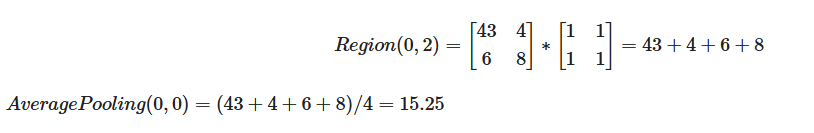


The below code computes for all other regions and yields feature map, i.e., avergage pooling result.

In [ ]:
# Q4's Answer: Script for solving Average Pooling

import numpy as np

# Define the input image X
X = np.array([
    [1, 17, 43, 4, 5],
    [2, 2, 6, 8, 7],
    [12, 9, 4, 45, 5],
    [3, 4, 78, 9, 62],
    [12, 11, 14, 42, 15]
])

# Define kernel size, stride, and padding
kernel_size = 2
stride = 2
padding = 1

# Perform average pooling
def average_pooling(image, kernel_size, stride, padding):
    # Add padding to the image
    padded_image = np.pad(image, ((0, padding), (0, padding)), mode='constant')

    # Calculate the dimensions of the output feature map
    output_dim = (padded_image.shape[0] - kernel_size) // stride + 1

    # Initialize the output feature map
    output = np.zeros((output_dim, output_dim))

    # Apply average pooling with the specified parameters
    for i in range(0, padded_image.shape[0] - kernel_size + 1, stride):
        for j in range(0, padded_image.shape[1] - kernel_size + 1, stride):
            region = padded_image[i:i + kernel_size, j:j + kernel_size]
            average = np.mean(region)
            print(f"Region at ({i}, {j}):\n{region}")
            print(f"Average: {average}\n")
            output[i // stride, j // stride] = average

    return output

# Perform average pooling on the input image
result = average_pooling(X, kernel_size, stride, padding)

# Print the final result
print("Resulting feature map [Average Pooling]:")
print(result)

Region at (0, 0):
[[ 1 17]
 [ 2  2]]
Average: 5.5

Region at (0, 2):
[[43  4]
 [ 6  8]]
Average: 15.25

Region at (0, 4):
[[5 0]
 [7 0]]
Average: 3.0

Region at (2, 0):
[[12  9]
 [ 3  4]]
Average: 7.0

Region at (2, 2):
[[ 4 45]
 [78  9]]
Average: 34.0

Region at (2, 4):
[[ 5  0]
 [62  0]]
Average: 16.75

Region at (4, 0):
[[12 11]
 [ 0  0]]
Average: 5.75

Region at (4, 2):
[[14 42]
 [ 0  0]]
Average: 14.0

Region at (4, 4):
[[15  0]
 [ 0  0]]
Average: 3.75

Resulting feature map [Average Pooling]:
[[ 5.5  15.25  3.  ]
 [ 7.   34.   16.75]
 [ 5.75 14.    3.75]]
